# Welcome to Time Series!

**Forecasting** is perhaps the most common application of machine learning in the real world. Businesses forecast product demand, governments forecast economic and population growth, meteorologists forecast the weather. The understanding of things to come is a pressing need across science, government, and industry, and practitioners in these fields are increasingly applying machine learning to address this need.

After these lectures, you'll know how to:
- engineer features to model the major time series components (*trends*, *seasons*, and *cycles*),
- visualize time series with many kinds of *time series plots*,
- create forecasting *hybrids* that combine the strengths of complementary models.



## Setting Up the Workspace

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from warnings import simplefilter

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess

## Loading the Data

In [ ]:
#import pandas as pd

walmart_data = pd.read_csv(
    "https://www.dropbox.com/s/ns7envvzoqyypui/Walmart_Store_sales.csv?dl=1",
    index_col='Date', dayfirst=True,
    parse_dates=['Date'],
)[['Weekly_Sales','Store']]


# 1. What is a Time Series? #

The basic object of forecasting is the **time series**, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

In [ ]:
df36 = walmart_data[walmart_data.Store == 36]
df36.head()

,Weekly_Sales,Store
Date,,
2010-02-05,467546.74,36
2010-02-12,469563.70,36
2010-02-19,470281.03,36
2010-02-26,447519.44,36
2010-03-05,480203.43,36


This series records the weekly sales at a single Walmart store over almost 3 years. Notice that we have a single column of observations `weekly_sales` with a time index `Date`.

## Linear Regression with Time Series

For the first part of this course, we'll use the linear regression algorithm to construct forecasting models. Linear regression is widely used in practice and adapts naturally to even complex forecasting tasks.

The **linear regression** algorithm learns how to make a weighted sum from its input features. For two features, we would have:

```
target = weight_1 * feature_1 + weight_2 * feature_2 + bias
```

During training, the regression algorithm learns values for the parameters `weight_1`, `weight_2`, and `bias` that best fit the `target`. (This algorithm is often called *ordinary least squares* since it chooses values that minimize the squared error between the target and the predictions.) The weights are also called *regression coefficients* and the `bias` is also called the *intercept* because it tells you where the graph of this function crosses the y-axis.

### Time-step features

There are two kinds of features unique to time series: time-step features and lag features.

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the **time dummy**, which counts off time steps in the series from beginning to end.

In [ ]:
#import numpy as np

#declare a column with the number of weeks in the data
df36['Week'] = np.arange(0, len(df36.index))  #np.arange() --> returns "a range" of evenly spaced values within a given interval from 0 to the total number of rows


df36.head()

<ipython-input-4-86bec004b520>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df36['Week'] = np.arange(0, len(df36.index))  #np.arange() --> returns "a range" of evenly spaced values within a given interval from 0 to the total number of rows


,Weekly_Sales,Store,Week
Date,,,
2010-02-05,467546.74,36,0
2010-02-12,469563.70,36,1
2010-02-19,470281.03,36,2
2010-02-26,447519.44,36,3
2010-03-05,480203.43,36,4


Linear regression with the time dummy produces the model:

```
target = weight * time + bias
```

The time dummy then lets us fit curves to time series in a *time plot*, where `Time` forms the x-axis.

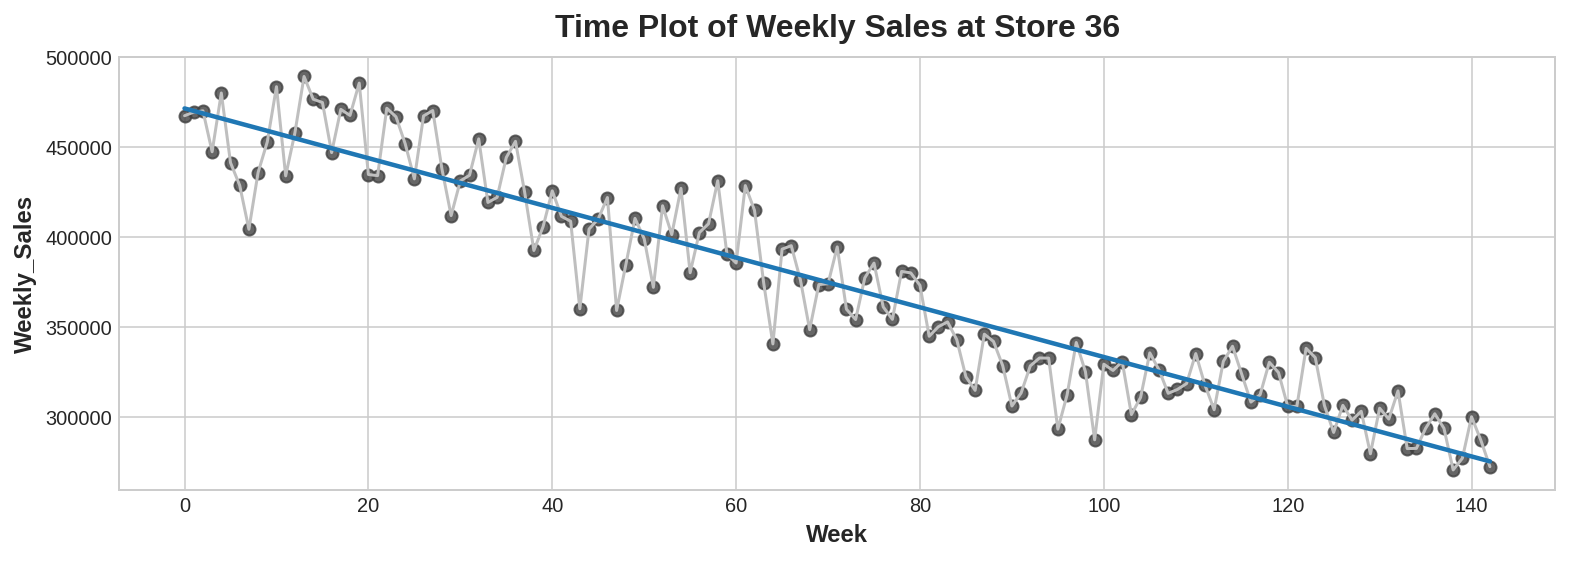

In [ ]:

#import matplotlib.pyplot as plt
#import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Week', 'Weekly_Sales', data=df36, color='0.75')
ax = sns.regplot(x='Week', y='Weekly_Sales', data=df36, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Weekly Sales at Store 36');

Time-step features let you model **time dependence**. A series is time dependent if its values can be predicted from the time they occured. In the *Weekly Sales* series, we can predict that weekly sales at this store later in the month are generally lower than sales earlier in the month.

### Lag features

To make a **lag feature** we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [ ]:
#shift the weekly sales column by 1 row. So that the lag_1 column of week 1 is the sales of week 0 (if we had daily sales, could shift instead eaasily by 7)
df36['Lag_1'] = df36['Weekly_Sales'].shift(1) 
df36 = df36.reindex(columns=['Weekly_Sales', 'Lag_1'])

df36.head()

<ipython-input-6-1b8fcc818ce3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df36['Lag_1'] = df36['Weekly_Sales'].shift(1)


,Weekly_Sales,Lag_1
Date,,
2010-02-05,467546.74,NaN
2010-02-12,469563.70,467546.74
2010-02-19,470281.03,469563.70
2010-02-26,447519.44,470281.03
2010-03-05,480203.43,447519.44


Linear regression with a lag feature produces the model:

```
target = weight * lag + bias
```

So lag features let us fit curves to *lag plots* where each observation in a series is plotted against the previous observation.

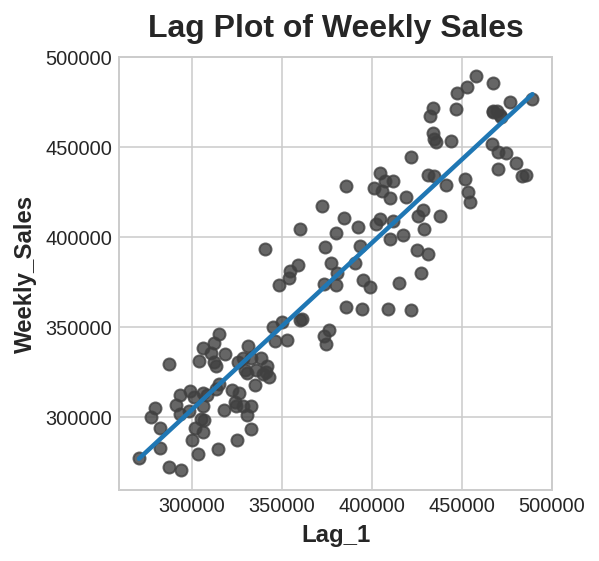

In [ ]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Weekly_Sales', data=df36, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Weekly Sales');

You can see from the lag plot that sales on one week (`Weekly_Sales`) are correlated with sales from the previous week (`Lag_1`). When you see a relationship like this, you know a lag feature will be useful.

More generally, lag features let you model **serial dependence**. A time series has serial dependence when an observation can be predicted from previous observations. In *Weekly Sales*, we can predict that high sales on one week usually mean lower sales the next week.

Adapting machine learning algorithms to time series problems is largely about feature engineering with the time index and lags. We use linear regression for its simplicity, but these features will be useful whichever algorithm you choose for your forecasting task.

## Example: Store 44

*Store 44* is a time series describing the weekly sales at another store with number 44. In this example, we'll get some practice applying linear regression to time-step features and lag features.

In [ ]:

#from pathlib import Path
#from warnings import simplefilter

#import matplotlib.pyplot as plt

#import numpy as np
#import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load store 44
df44 = walmart_data[walmart_data.Store == 44]
# Create a time series in Pandas by setting the index to a date
# column. 
#df44 = df44.set_index("Date")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
df44 = df44.to_period()

df44.head()

,Weekly_Sales,Store
Date,,
2010-01-30/2010-02-05,281090.95,44
2010-02-06/2010-02-12,286857.13,44
2010-02-13/2010-02-19,267956.30,44
2010-02-20/2010-02-26,273079.07,44
2010-02-27/2010-03-05,284617.27,44


### Time-step features

Provided the time series doesn't have any missing dates, we can create a time dummy by counting out the length of the series.

In [ ]:
#declare a column with the number of weeks in the data
#np.arange() --> returns "a range" of evenly spaced values within a given interval from 0 to the total number of rows
df44['Time'] = np.arange(len(df44.index))

df44.head()

,Weekly_Sales,Store,Time
Date,,,
2010-01-30/2010-02-05,281090.95,44,0
2010-02-06/2010-02-12,286857.13,44,1
2010-02-13/2010-02-19,267956.30,44,2
2010-02-20/2010-02-26,273079.07,44,3
2010-02-27/2010-03-05,284617.27,44,4


The procedure for fitting a linear regression model follows the standard steps for scikit-learn.

In [ ]:
#from sklearn.linear_model import LinearRegression

# Training data
X = df44.loc[:, ['Time']]  # features
y = df44.loc[:, 'Weekly_Sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

In [ ]:
model.coef_

array([470.75004793])

In [ ]:
model.intercept_

269325.61261072266

The model actually created is (approximately): `Weekly_Sales = 470.75 * Time + 269326`. Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation.

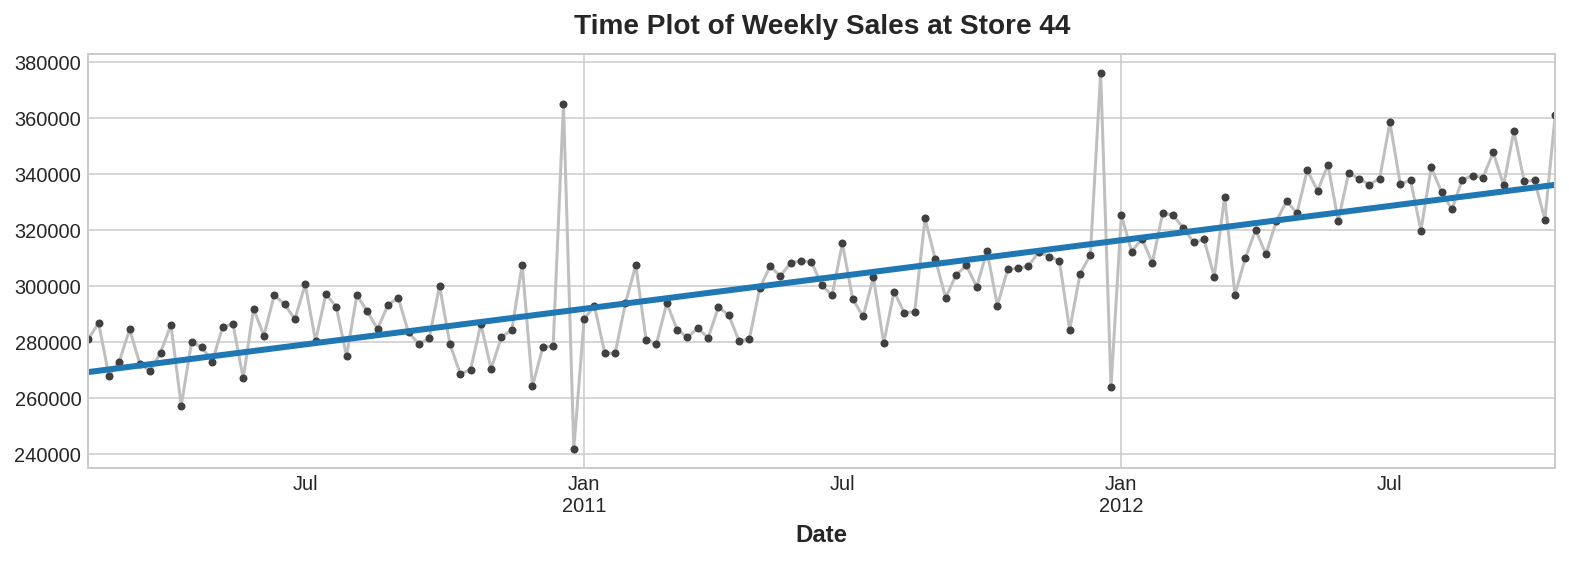

In [ ]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Weekly Sales at Store 44');

### Lag features

Pandas provides us a simple method to lag a series, the `shift` method.

In [ ]:
df44['Lag_1'] = df44['Weekly_Sales'].shift(1)
df44.head()

,Weekly_Sales,Store,Time,Lag_1
Date,,,,
2010-01-30/2010-02-05,281090.95,44,0,NaN
2010-02-06/2010-02-12,286857.13,44,1,281090.95
2010-02-13/2010-02-19,267956.30,44,2,286857.13
2010-02-20/2010-02-26,273079.07,44,3,267956.30
2010-02-27/2010-03-05,284617.27,44,4,273079.07


When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [ ]:
#from sklearn.linear_model import LinearRegression

X = df44.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df44.loc[:, 'Weekly_Sales']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

The lag plot shows us how well we were able to fit the relationship between the wekely sales one week and the number the previous week.

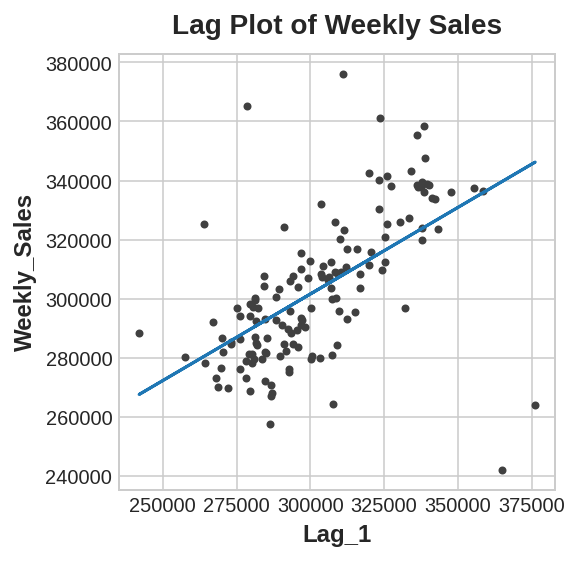

In [ ]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Weekly_Sales')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Weekly Sales');

What does this prediction from a lag feature mean about how well we can predict the series across time? The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past.

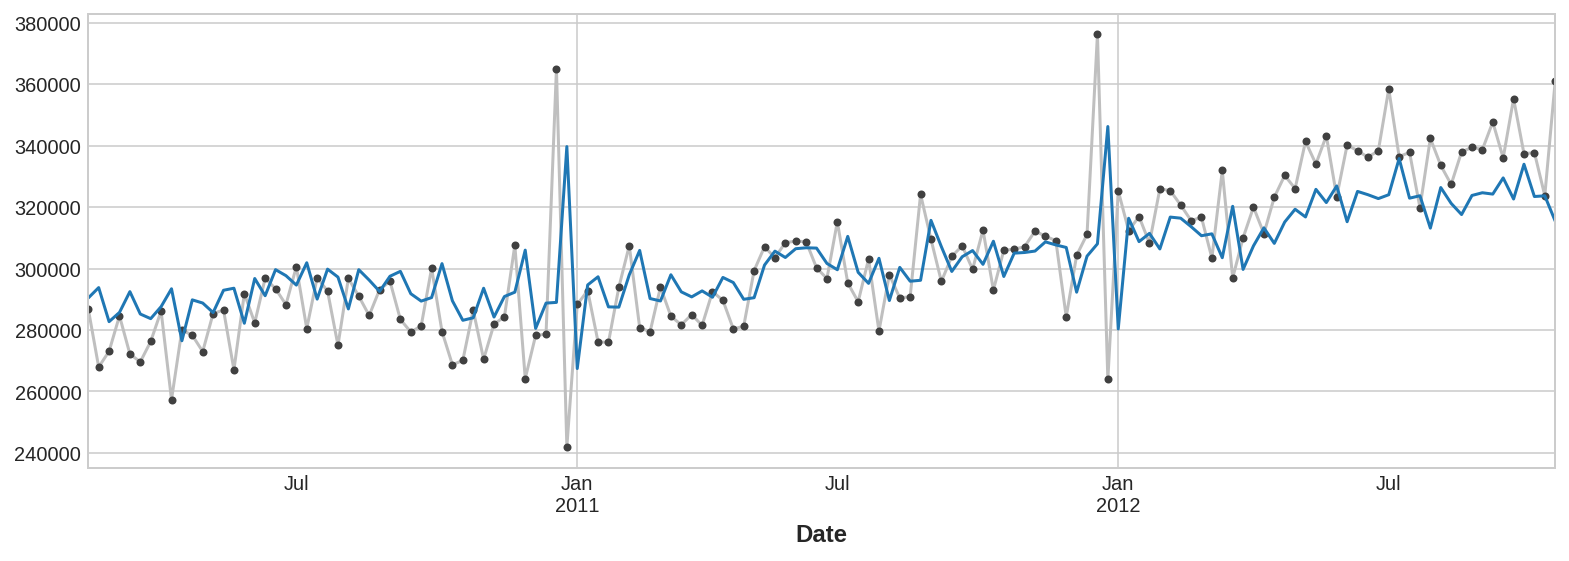

In [ ]:

ax = y.plot(**plot_params)
ax = y_pred.plot()

## Take-away: What is a Times Series? 
*The best time series models will usually include some combination of time-step features and lag features.*

Next, we'll learn how to engineer features modeling the most common patterns in time series using the features introduced in this section as a starting point.

---
# 2. What is Trend?

The **trend** component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

In this course, we'll focus on trends in the mean. More generally though, any persistent and slow-moving change in a series could constitute a trend -- time series commonly have trends in their variation for instance.

## Moving Average Plots 

To see what kind of trend a time series might have, we can use a **moving average plot**. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

Suppose we have a multi-year series with a repeating up and down movement year after year -- a short-term, *seasonal* change. For a change to be a part of the trend, it should occur over a longer period than any seasonal changes. To visualize a trend, therefore, we take an average over a period longer than any seasonal period in the series. For a yearly repeating series, we chose a window of size 12 months (monthly data) or 52 weeks (weekly data) or 365 days (daily data) to smooth over the season within each year.

## Engineering Trend

Once we've identified the shape of the trend, we can attempt to model it using a time-step feature. We've already seen how using the time dummy itself will model a linear trend:

```
target = a * time + b
```

We can fit many other kinds of trend through transformations of the time dummy. If the trend appears to be quadratic (a parabola), we just need to add the square of the time dummy to the feature set, giving us:
```
target = a * time ** 2 + b * time + c
```
Linear regression will learn the coefficients `a`, `b,` and `c`.

If you haven't seen the trick before, you may not have realized that linear regression can fit curves other than lines. The idea is that if you can provide curves of the appropriate shape as features, then linear regression can learn how to combine them in the way that best fits the target.

## Example: Store 44

In this example we'll create a trend model for the *Walmart Weekly Sales* dataset.

In [ ]:

#from pathlib import Path
#from warnings import simplefilter

#import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Walmart dataset
walmart_data = pd.read_csv(
    "https://www.dropbox.com/s/ns7envvzoqyypui/Walmart_Store_sales.csv?dl=1",
    index_col='Date', dayfirst=True,
    parse_dates=['Date'],
)[['Weekly_Sales','Store']]

df44 = walmart_data[walmart_data.Store == 44].drop('Store',axis=1)
df44.head()

,Weekly_Sales
Date,
2010-02-05,281090.95
2010-02-12,286857.13
2010-02-19,267956.30
2010-02-26,273079.07
2010-03-05,284617.27


Let's make a moving average plot to see what kind of trend this series has. Since this series has weekly observations, let's choose a window of 52 weeks to smooth over any short-term changes within the year.

To create a moving average, first use the `rolling` method to begin a windowed computation. Follow this by the `mean` method to compute the average over the window. As we can see, the trend of *Weekly Sales* appears to be about linear.

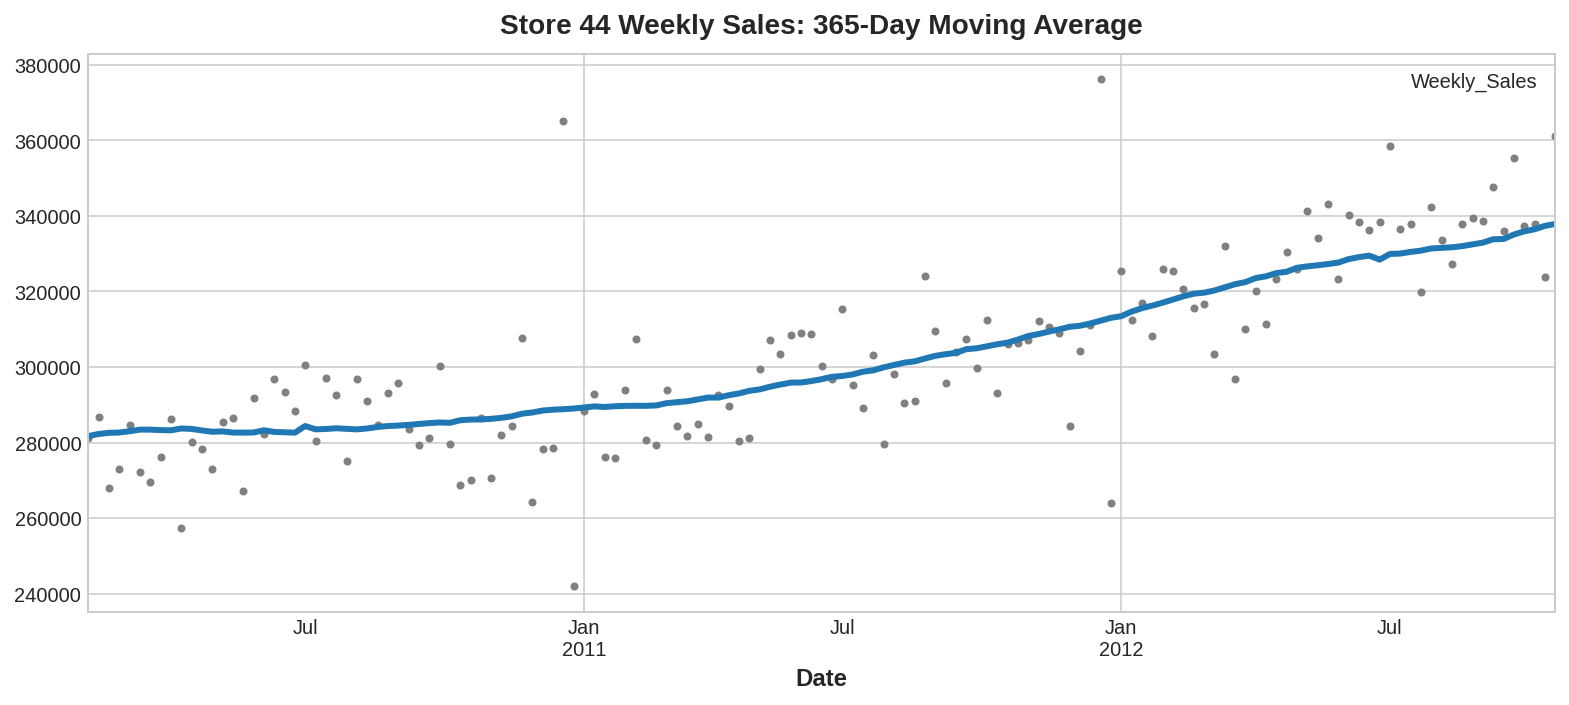

In [ ]:
moving_average = df44.rolling(
    window=52,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=26,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df44.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Store 44 Weekly Sales: 365-Day Moving Average", legend=False,
);

In section 1, we engineered our time dummy in Pandas directly. From now on, however, we'll use a function from the `statsmodels` library called `DeterministicProcess`. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The `order` argument refers to polynomial order: `1` for linear, `2` for quadratic, `3` for cubic, and so on.

In [ ]:
#from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df44.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Date,,
2010-02-05,1.0,1.0
2010-02-12,1.0,2.0
2010-02-19,1.0,3.0
2010-02-26,1.0,4.0
2010-03-05,1.0,5.0


A *deterministic process* is a technical term for a time series that is non-random or completely *determined*, like the `const` and `trend` series are. Features derived from the time index will generally be deterministic.

We create our trend model basically as before, though note the addition of the `fit_intercept=False` argument.

In [ ]:
#from sklearn.linear_model import LinearRegression

y = df44["Weekly_Sales"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [ ]:
y_pred.tail(5)

Date
2012-09-28    334289.119226
2012-10-05    334759.869273
2012-10-12    335230.619321
2012-10-19    335701.369369
2012-10-26    336172.119417
dtype: float64

The trend discovered by our `LinearRegression` model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

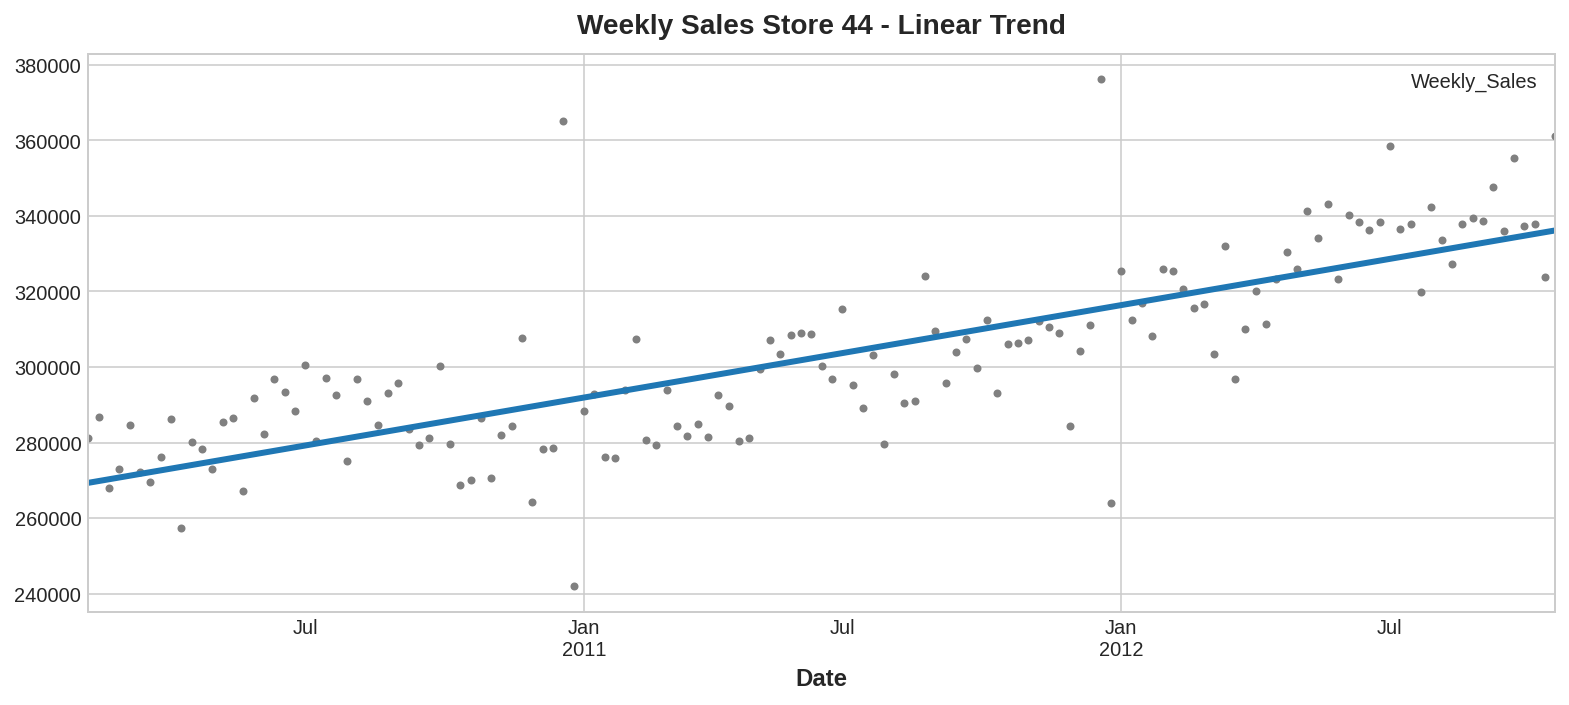

In [ ]:
ax = df44.plot(style=".", color="0.5", title="Weekly Sales Store 44 - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a half year forecast:

In [ ]:
X = dp.out_of_sample(steps=26)

y_fore = pd.Series(model.predict(X), index=X.index).to_frame('Weekly_Sales').reset_index()
#Set date as index for predictions
def add_timeindex(row):
    return pd.to_datetime('2010-01-29') + pd.DateOffset(weeks=row['index'])
y_fore['Date'] = y_fore.apply(add_timeindex,axis=1)
y_fore = y_fore.set_index('Date').drop('index',axis=1)

y_fore.head()

,Weekly_Sales
Date,
2012-11-02,336642.869465
2012-11-09,337113.619513
2012-11-16,337584.369561
2012-11-23,338055.119609
2012-11-30,338525.869657


Let's plot a portion of the series to see the trend forecast for the next half year:

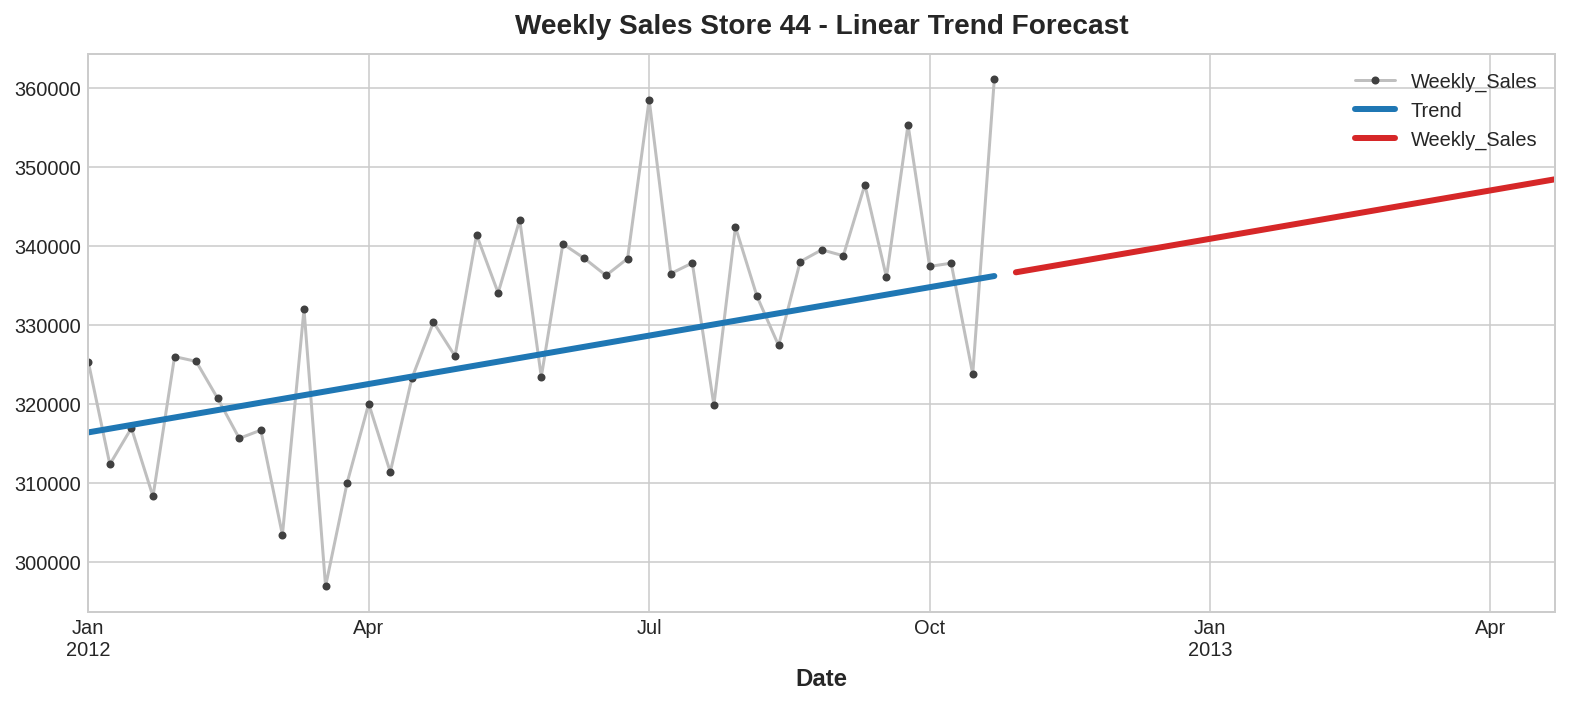

In [ ]:
ax = df44["2012-01-01":].plot(title="Weekly Sales Store 44 - Linear Trend Forecast", **plot_params)
ax = y_pred["2012-01-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

## Take-away: What is Trend?

*The trend models we learned about in this lesson turn out to be useful for a number of reasons. Besides acting as a baseline or starting point for more sophisticated models, we can also use them as a component in a "hybrid model" with algorithms unable to learn trends -- like Random Forests and XGBoost!*

---
# 3. What is Seasonality? 

We say that a time series exhibits **seasonality** whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations. We will return to this later.

## Seasonal Plots and Seasonal Indicators

Just like we used a moving average plot to discover the trend in a series, we can use a **seasonal plot** to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. The figure below shows an example of a seasonal plot of the daily values plotted over a common *weekly* period.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/bd7D4NJ.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>There is a clear weekly seasonal pattern in this series, higher on weekdays and falling towards the weekend.
</center></figcaption>
</figure>

## Seasonal indicators

**Seasonal indicators** are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

By one-hot encoding days of the week, we get weekly seasonal indicators. Creating weekly indicators for the series will then give us six new "dummy" features. Linear regression works best if you drop one of the indicators; we chose Monday in the frame below.


| Date       | Tuesday | Wednesday | Thursday | Friday | Saturday | Sunday |
|------------|---------|-----------|----------|--------|----------|--------|
| 2016-01-04 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-05 | 1.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-06 | 0.0     | 1.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-07 | 0.0     | 0.0       | 1.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-08 | 0.0     | 0.0       | 0.0      | 1.0    | 0.0      | 0.0    |
| 2016-01-09 | 0.0     | 0.0       | 0.0      | 0.0    | 1.0      | 0.0    |
| 2016-01-10 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 1.0    |
| 2016-01-11 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| ...        | ...     | ...       | ...      | ...    | ...      | ...    |

Adding seasonal indicators to the training data helps models distinguish means within a seasonal period:

<figure style="padding: 1em;">
<img src="https://i.imgur.com/hIlF5j5.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Ordinary linear regression learns the mean values at each time in the season.</center></figcaption>
</figure>

The indicators act as On / Off switches. At any time, at most one of these indicators can have a value of `1` (*On*). Linear regression learns a baseline value `2379` for `Mon` and then adjusts by the value of whichever indicator is *On* for that day; the rest are `0` and vanish.

## Example: Store 44

We'll continue once more with the *Walmart Stores* dataset. We load the data and define two functions: `seasonal_plot` and `plot_periodogram`.

In [ ]:

#from pathlib import Path
#from warnings import simplefilter

#import matplotlib.pyplot as plt
#import pandas as pd
#import seaborn as sns
#from sklearn.linear_model import LinearRegression
#from statsmodels.tsa.deterministic import DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

walmart_data = pd.read_csv(
    "https://www.dropbox.com/s/ns7envvzoqyypui/Walmart_Store_sales.csv?dl=1",
    index_col='Date', dayfirst=True,
    parse_dates=['Date'],
)[['Weekly_Sales','Store','Holiday_Flag']]

df44 = walmart_data[walmart_data.Store == 44].drop('Store',axis=1)
df44.head()
df44 = df44.to_period("W")

Let's take a look at weekly seasonal plots over a year.

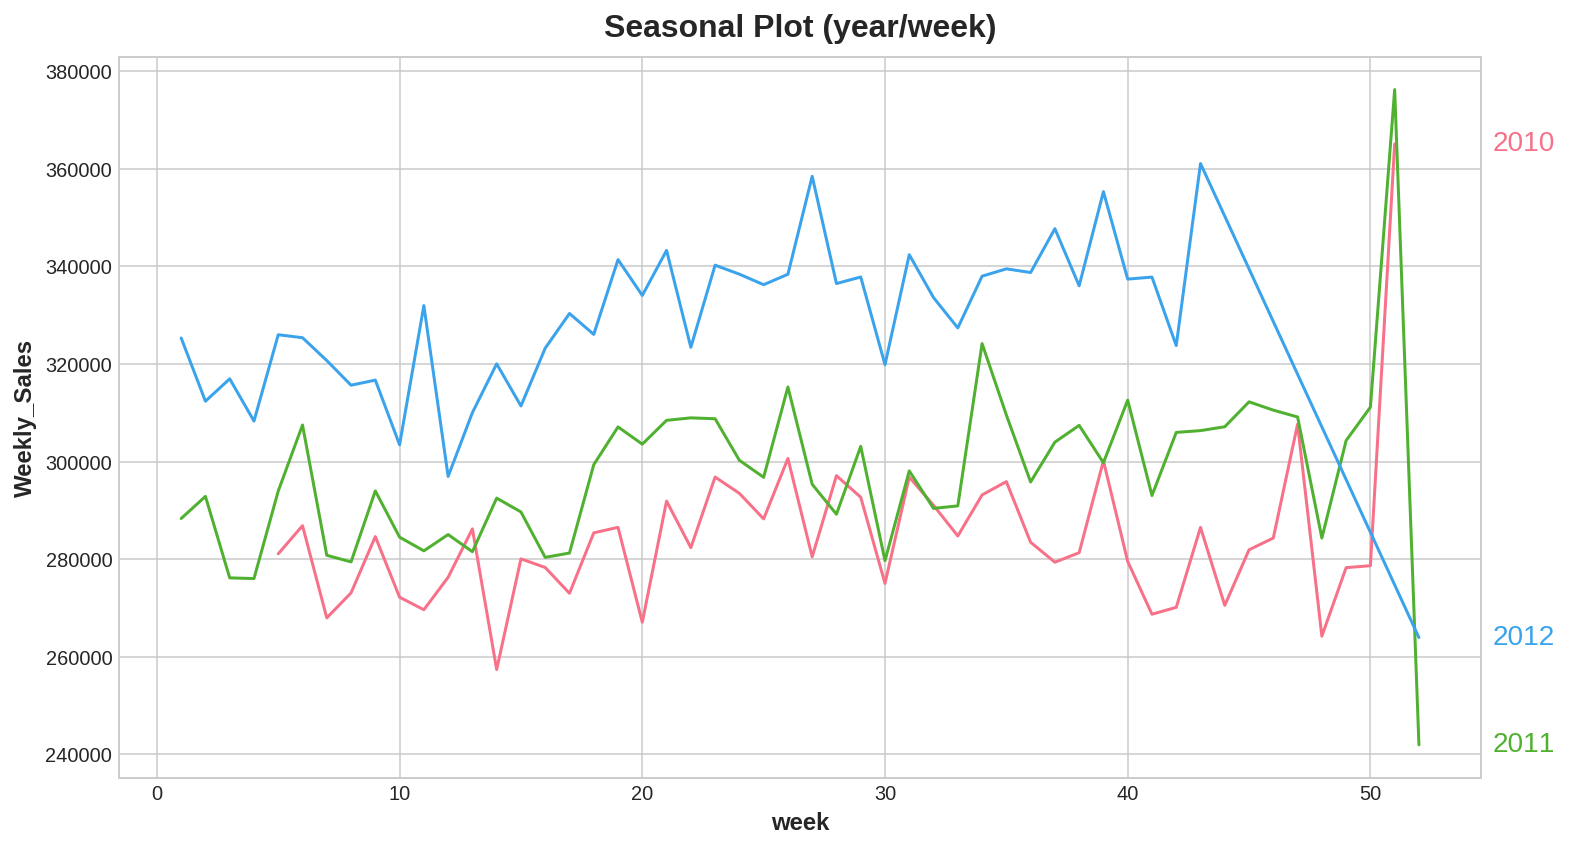

In [ ]:
X = df44.copy()

X["month"] = X.index.month  # the x-axis (freq)
X["year"] = X.index.year  # the seasonal period (period)

X["week"] = X.index.week
X["quarter"] = X.index.quarter

#fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
seasonal_plot(X, y="Weekly_Sales", period="year", freq="week", ax=ax)

#seasonal_plot(X, y="Weekly_Sales", period="quarter", freq="week", ax=ax1);

We'll create our seasonal features using `DeterministicProcess`, the same utility we used in section 2 to create trend features. 

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df44.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for weeks

With our feature set created, we're ready to fit the model and make predictions. We'll add a 90-day forecast to see how our model extrapolates beyond the training data. The code here is the same as that in earlier lessons.

In [ ]:
X

,const,trend,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)",...,"s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)","s(51,52)","s(52,52)"
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01/2010-02-07,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02-08/2010-02-14,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02-15/2010-02-21,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-02-22/2010-02-28,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-01/2010-03-07,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-24/2012-09-30,1.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-01/2012-10-07,1.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-10-08/2012-10-14,1.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


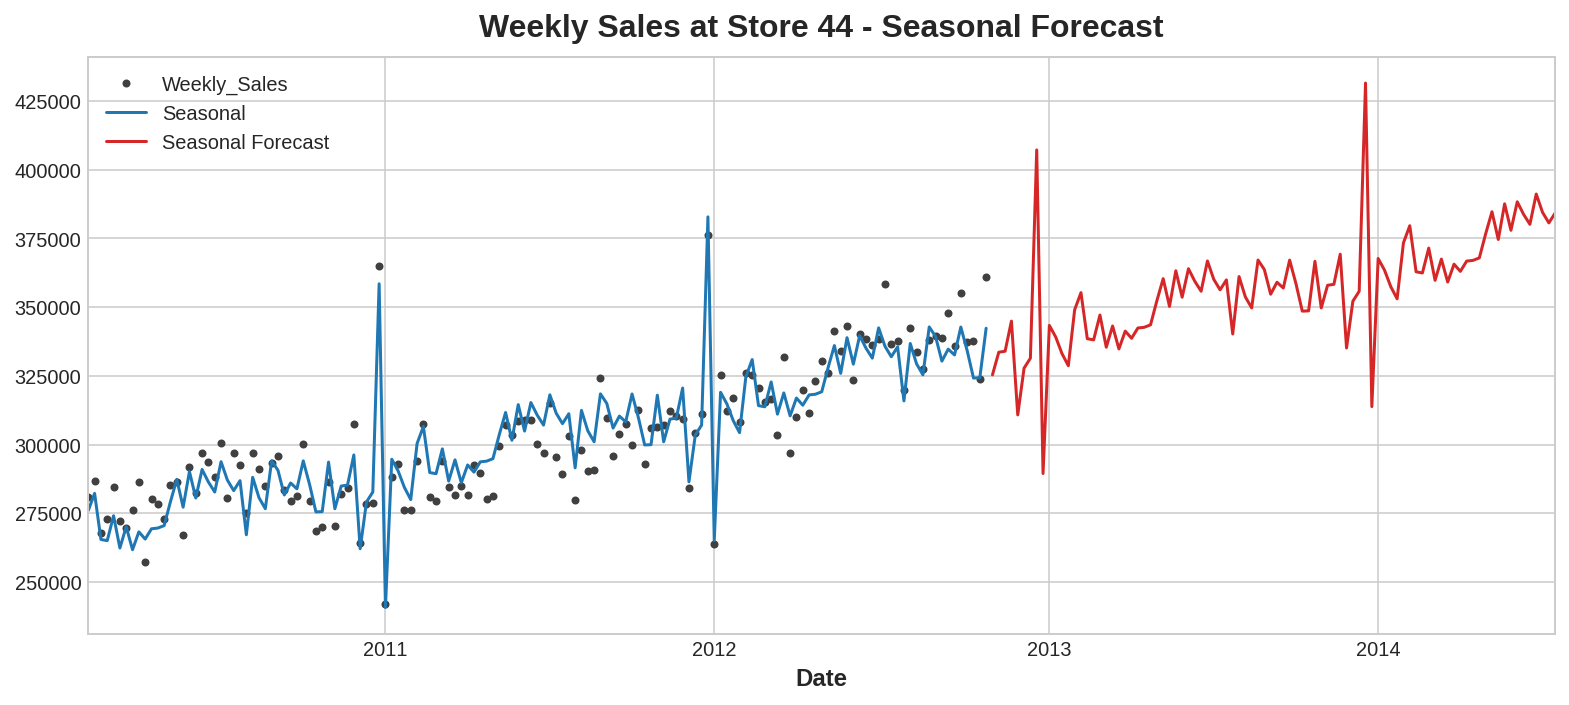

In [ ]:
y = df44["Weekly_Sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Weekly Sales at Store 44 - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()


There's still more we can do with time series to improve our forecasts. Next lecture, we'll learn how to use **Fourier series** to model seasonality in a much more elegant way than the 52 one-hot week dummies that we used our model above. When feasible, using Fourier series is useful to avoid overfitting when we have high cardinality of seasonal dummies as in the case of the weekly indicators. 

We will also learn how to use time series themselves as a features. Using time series as inputs to a forecast lets us model another component in addition to trend and seasonality often found in series: *Cycles*.